In [1]:
"""
Author: Bryan Bo Cao
Email: boca7588@colorado.edu or bo.cao-1@colorado.edu
Github Repo: https://github.com/BryanBo-Cao/neuralnets-deeplearning
Reference:
    https://github.com/tylersco/deep-neural-networks-art-images
    http://www.scipy-lectures.org/advanced/image_processing/
"""
from scipy import misc
import scipy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import glob
import pandas as pd
import csv
import math
from __future__ import division, print_function, absolute_import
from data.img.ArtDataLoader import ArtData
from Plotter import plot_acc_distance
from Plotter import plot_acc_cosine
from MySpearman import get_correlation_distance
from MySpearman import get_correlation_cosine

In [2]:
from scipy import misc
art_data = ArtData()
art_data.load_all_data()
#art_data.load_images()
#art_data.load_metadata()

ArtData Initialized!
2592  images loaded!


In [3]:
#print(art_data.train_images.keys())
print(art_data.alpha_pairs['same'][0][95])
print(art_data.beta_pairs['same'][0][95])

print(art_data.alpha_pairs['diff'][0][95])
print(art_data.beta_pairs['diff'][0][95])

2018-impressionist-16x16.jpg
2134-impressionist-16x16.jpg
1233-cubist-16x16.jpg
1185-cubist-16x16.jpg


In [4]:
print(art_data.train_images['0001-cubist-16x16.jpg'].shape)

(16, 16, 3)


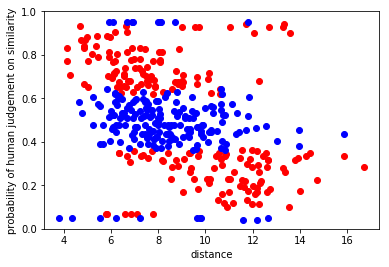

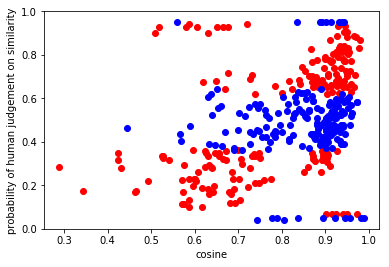

In [5]:
#Raw data
plot_acc_distance(art_data)
plot_acc_cosine(art_data)

In [6]:
get_correlation_distance(art_data)

SpearmanrResult(correlation=-0.43703209932016235, pvalue=2.4205529647121813e-19)

In [7]:
get_correlation_cosine(art_data)

SpearmanrResult(correlation=0.39397345868637601, pvalue=1.0416440743593834e-15)

In [8]:
#start of autoencoder
'''
Reference:
https://github.com/MorvanZhou/tutorials/edit/master/tensorflowTUT/tf21_autoencoder/full_code.py
My tutorial website: https://morvanzhou.github.io/tutorials/
'''
learning_rate = 0.01
training_epochs = 100
batch_size = 256
display_step = 1
# Network Parameters
#n_input = 784  # MNIST data input (img shape: 28*28)
n_input = 768 # image data input (img shape: 16*16*3)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])

# hidden layer settings
n_hidden_1 = 128
n_hidden_2 = 64
n_hidden_3 = 10
n_hidden_4 = 2

weights = {
    'encoder_h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1],)),
    'encoder_h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2],)),
    'encoder_h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3],)),
    'encoder_h4': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_4],)),

    'decoder_h1': tf.Variable(tf.truncated_normal([n_hidden_4, n_hidden_3],)),
    'decoder_h2': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_2],)),
    'decoder_h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_1],)),
    'decoder_h4': tf.Variable(tf.truncated_normal([n_hidden_1, n_input],)),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'encoder_b4': tf.Variable(tf.random_normal([n_hidden_4])),

    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_3])),
    'decoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b3': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b4': tf.Variable(tf.random_normal([n_input])),
}


def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                   biases['encoder_b3']))
    layer_4 = tf.add(tf.matmul(layer_3, weights['encoder_h4']),
                                    biases['encoder_b4'])
    return layer_4


def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                biases['decoder_b3']))
    layer_4 = tf.nn.sigmoid(tf.add(tf.matmul(layer_3, weights['decoder_h4']),
                                biases['decoder_b4']))
    return layer_4


In [9]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


# Launch the graph
with tf.Session() as sess:
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)
    total_batch = int(len(art_data.train_images) / batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = art_data.next_batch(batch_size)  # max(x) = 1, min(x) = 0
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")

Epoch: 0001 cost= 0.142158762
Epoch: 0002 cost= 0.099095762
Epoch: 0003 cost= 0.082367294
Epoch: 0004 cost= 0.073253788
Epoch: 0005 cost= 0.072014026
Epoch: 0006 cost= 0.066160209
Epoch: 0007 cost= 0.062705241
Epoch: 0008 cost= 0.065718971
Epoch: 0009 cost= 0.065208308
Epoch: 0010 cost= 0.062660731
Epoch: 0011 cost= 0.057039861
Epoch: 0012 cost= 0.062011931
Epoch: 0013 cost= 0.062743373
Epoch: 0014 cost= 0.063318536
Epoch: 0015 cost= 0.062565207
Epoch: 0016 cost= 0.065468945
Epoch: 0017 cost= 0.062814146
Epoch: 0018 cost= 0.059654236
Epoch: 0019 cost= 0.061028704
Epoch: 0020 cost= 0.060260307
Epoch: 0021 cost= 0.056387436
Epoch: 0022 cost= 0.046964753
Epoch: 0023 cost= 0.052927803
Epoch: 0024 cost= 0.056551877
Epoch: 0025 cost= 0.056020111
Epoch: 0026 cost= 0.053663969
Epoch: 0027 cost= 0.054171991
Epoch: 0028 cost= 0.054657917
Epoch: 0029 cost= 0.052056149
Epoch: 0030 cost= 0.056886245
Epoch: 0031 cost= 0.054870386
Epoch: 0032 cost= 0.054038044
Epoch: 0033 cost= 0.044455320
Epoch: 003